In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle as pkl
import sys
import seaborn as sns

from fastFM import als
from fastFM.datasets import make_user_item_regression
from scipy.sparse import csc_matrix, hstack, vstack
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, roc_curve, precision_recall_curve
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK

% matplotlib inline
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.3)

# Import data

In [2]:
# import full data
data_path = os.path.join('..', 'data-2')
splits_path = os.path.join(data_path,'splits')
sparse_path = os.path.join(data_path, 'sparse')
columns = ['user','item','rating']

with open(os.path.join(splits_path, 'train.df'), 'rb') as file_in:
    train_df = pkl.load(file_in)
    
with open(os.path.join(splits_path, 'dev.df'), 'rb') as file_in:
    cv_df = pkl.load(file_in)
    
with open(os.path.join(splits_path, 'test.df'), 'rb') as file_in:
    test_df = pkl.load(file_in)
        
# import results from LSH, Baseline, FM with ratings only, and FM with LSH and Baseline results as features
results_lsh_train = pd.read_csv(os.path.join(data_path, 'results_lsh_train.csv'))
results_lsh_cv = pd.read_csv(os.path.join(data_path, 'results_lsh_cv.csv'))
results_lsh_test = pd.read_csv(os.path.join(data_path, 'results_lsh_test.csv'))

results_baseline_train = pd.read_csv(os.path.join(data_path, 'results_baseline_train.csv'))
results_baseline_cv = pd.read_csv(os.path.join(data_path, 'results_baseline_cv.csv'))
results_baseline_test = pd.read_csv(os.path.join(data_path, 'results_baseline_test.csv'))

results_fm_ratings_train = pd.read_csv(os.path.join(data_path, 'results_fm_ratings_train.csv'))
results_fm_ratings_cv = pd.read_csv(os.path.join(data_path, 'results_fm_ratings_cv.csv'))
results_fm_ratings_test = pd.read_csv(os.path.join(data_path, 'results_fm_ratings_test.csv'))

results_fm_lsh_train = pd.read_csv(os.path.join(data_path, 'results_fm_lsh_train.csv'))
results_fm_lsh_cv = pd.read_csv(os.path.join(data_path, 'results_fm_lsh_cv.csv'))
results_fm_lsh_test = pd.read_csv(os.path.join(data_path, 'results_fm_lsh_test.csv'))

results_ensemble_train = pd.read_csv(os.path.join(data_path, 'results_ensemble_train.csv'))
results_ensemble_cv = pd.read_csv(os.path.join(data_path, 'results_ensemble_cv.csv'))
results_ensemble_test = pd.read_csv(os.path.join(data_path, 'results_ensemble_test.csv'))

train_df['pred_lsh'] = results_lsh_train['prediction'].values
train_df['pred_baseline'] = results_baseline_train['pred'].values
train_df['pred_fm_ratings'] = np.clip(results_fm_ratings_train['prediction'].values, a_min=1, a_max=5)
train_df['pred_fm_lsh'] = np.clip(results_fm_lsh_train['prediction'].values, a_min=1, a_max=5)
train_df['pred_ensemble'] = np.clip(results_ensemble_train['prediction'].values, a_min=1, a_max=5)

cv_df['pred_lsh'] = results_lsh_cv['prediction'].values
cv_df['pred_baseline'] = results_baseline_cv['pred'].values
cv_df['pred_fm_ratings'] = np.clip(results_fm_ratings_cv['prediction'].values,  a_min=1, a_max=5)
cv_df['pred_fm_lsh'] = np.clip(results_fm_lsh_cv['prediction'].values, a_min=1, a_max=5)
cv_df['pred_ensemble'] = np.clip(results_ensemble_cv['prediction'].values, a_min=1, a_max=5)

test_df['pred_lsh'] = results_lsh_test['prediction'].values
test_df['pred_baseline'] = results_baseline_test['pred'].values
test_df['pred_fm_ratings'] = np.clip(results_fm_ratings_test['prediction'].values, a_min=1, a_max=5)
test_df['pred_fm_lsh'] = np.clip(results_fm_lsh_test['prediction'].values, a_min=1, a_max=5)
test_df['pred_ensemble'] = np.clip(results_ensemble_test['prediction'].values, a_min=1, a_max=5)

### Additional data cleaning

In [3]:
# convert years to ints
train_df['year'] = train_df['year'].apply(lambda x: x[0:4]).astype(int)
cv_df['year'] = cv_df['year'].apply(lambda x: x[0:4]).astype(int)
test_df['year'] = test_df['year'].apply(lambda x: x[0:4]).astype(int)

### Calculate absolute error

In [7]:
train_df['err_lsh'] = np.abs(train_df['pred_lsh'] - train_df['rating'])
train_df['err_baseline'] = np.abs(train_df['pred_baseline'] - train_df['rating'])
train_df['err_fm_ratings'] = np.abs(train_df['pred_fm_ratings'] - train_df['rating'])
train_df['err_fm_lsh'] = np.abs(train_df['pred_fm_lsh'] - train_df['rating'])
train_df['err_ensemble'] = np.abs(train_df['pred_ensemble'] - train_df['rating'])

cv_df['err_lsh'] = np.abs(cv_df['pred_lsh'] - cv_df['rating'])
cv_df['err_baseline'] = np.abs(cv_df['pred_baseline'] - cv_df['rating'])
cv_df['err_fm_ratings'] = np.abs(cv_df['pred_fm_ratings'] - cv_df['rating'])
cv_df['err_fm_lsh'] = np.abs(cv_df['pred_fm_lsh'] - cv_df['rating'])
cv_df['err_ensemble'] = np.abs(cv_df['pred_ensemble'] - cv_df['rating'])

test_df['err_lsh'] = np.abs(test_df['pred_lsh'] - test_df['rating'])
test_df['err_baseline'] = np.abs(test_df['pred_baseline'] - test_df['rating'])
test_df['err_fm_ratings'] = np.abs(test_df['pred_fm_ratings'] - test_df['rating'])
test_df['err_fm_lsh'] = np.abs(test_df['pred_fm_lsh'] - test_df['rating'])
test_df['err_ensemble'] = np.abs(test_df['pred_ensemble'] - test_df['rating'])

data = dict(train=train_df, cv=cv_df, test=test_df)

# Analysis

In [8]:
# Calculate mean baseline
mean = train_df['rating'].mean()
for key, df in data.items():
    df['pred_baseline_mean'] = mean
    df['err_baseline_mean'] = np.abs(df['rating'] - mean)


errors = ['err_baseline_mean', 'err_lsh', 'err_baseline', 'err_fm_ratings', 'err_fm_lsh', 'err_ensemble']
error_data = list()
for key, df in data.items():
    row = list()
    for error in errors:
        row.append(df[error].mean())
    error_data.append(row)
error_data = pd.DataFrame(error_data, columns=errors, index=data.keys())
error_data

,err_baseline_mean,err_lsh,err_baseline,err_fm_ratings,err_fm_lsh,err_ensemble
train,0.941307,0.776285,0.690115,0.642497,0.645602,0.634640
cv,0.938894,0.790865,0.725451,0.717786,0.719750,0.717471
test,0.941661,0.787686,0.718741,0.712174,0.712980,0.711717


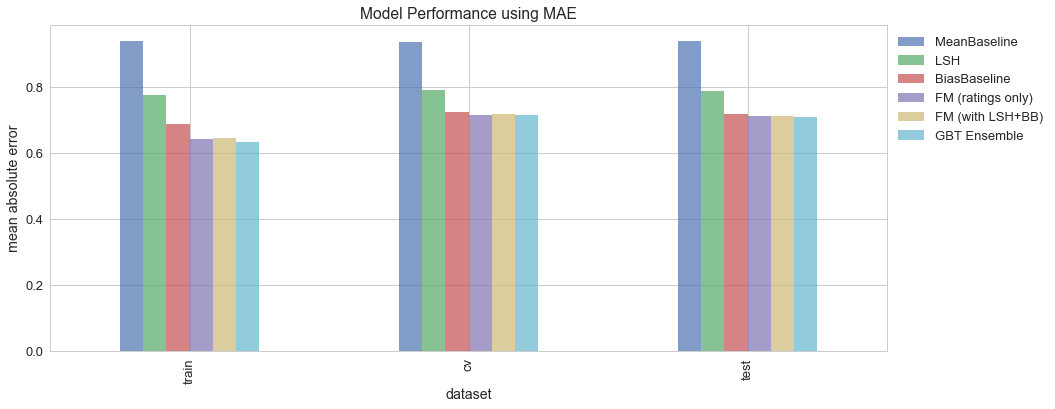

In [9]:
ax = error_data.plot(kind = 'bar', figsize = (15,6), alpha = 0.7)
ax.legend(['MeanBaseline','LSH','BiasBaseline','FM (ratings only)','FM (with LSH+BB)', 'GBT Ensemble'],
            loc = 'best', bbox_to_anchor = (1.2,1))
__ = ax.set(xlabel = 'dataset', ylabel = 'mean absolute error', title = 'Model Performance using MAE')

In [10]:
def calc_auc(y, y_pred):
    y = (y >= 4)
    y_pred = y_pred / y_pred.max()
    auc = roc_auc_score(y, y_pred)
    return auc

preds = ['pred_baseline_mean','pred_lsh', 'pred_baseline', 'pred_fm_ratings', 'pred_fm_lsh', 'pred_ensemble']
auc_data = list()
for key, df in data.items():
    row = list()
    for pred in preds:
        auc = calc_auc(df['rating'], df[pred])
        row.append(auc)
    auc_data.append(row)
auc_data = pd.DataFrame(auc_data, columns = preds, index=data.keys())
auc_data

,pred_baseline_mean,pred_lsh,pred_baseline,pred_fm_ratings,pred_fm_lsh,pred_ensemble
train,0.5,0.771787,0.842967,0.871505,0.871109,0.872138
cv,0.5,0.762181,0.814528,0.816789,0.816938,0.816143
test,0.5,0.767861,0.820651,0.821890,0.822598,0.821585


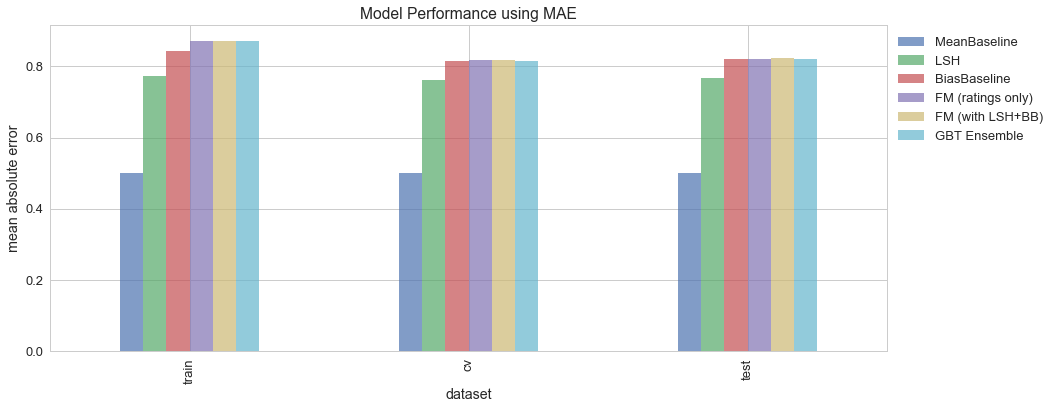

In [11]:
ax = auc_data.plot(kind = 'bar', figsize = (15,6), alpha = 0.7)
ax.legend(['MeanBaseline','LSH','BiasBaseline','FM (ratings only)','FM (with LSH+BB)', 'GBT Ensemble'],
            loc = 'best', bbox_to_anchor = (1.2,1))
__ = ax.set(xlabel = 'dataset', ylabel = 'mean absolute error', title = 'Model Performance using MAE')

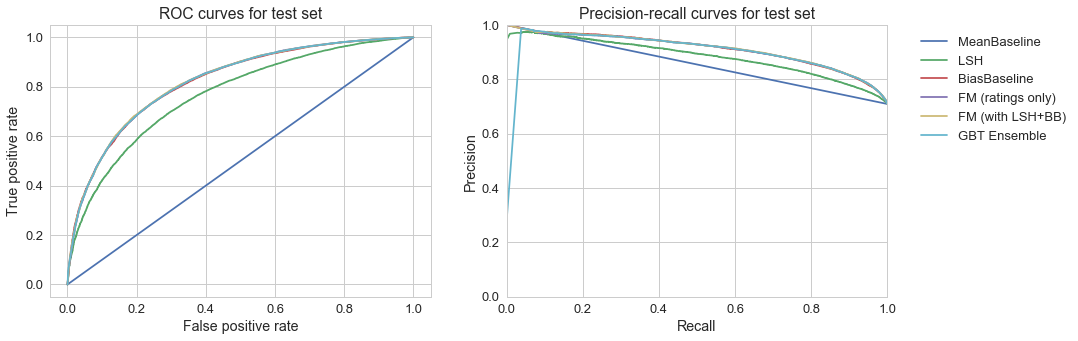

In [12]:
y_test_pred = (data['test']['rating'] >= 4)
fig, axes = plt.subplots(1, 2, figsize=(15,5))
for pred in preds:
    fpr, tpr, thresholds = roc_curve(y_true=y_test_pred, y_score=data['test'][pred])
    precision, recall, thresholds = precision_recall_curve(y_true=y_test_pred, probas_pred=data['test'][pred])
    axes[0].plot(fpr, tpr)
    axes[1].plot(recall, precision)
axes[0].set(xlabel = 'False positive rate', ylabel = 'True positive rate', title = 'ROC curves for test set')
axes[1].set(xlabel = 'Recall', ylabel = 'Precision', title = 'Precision-recall curves for test set',
           xlim = (0,1), ylim = (0,1))
axes[1].legend(['MeanBaseline','LSH','BiasBaseline','FM (ratings only)','FM (with LSH+BB)', 'GBT Ensemble'],
            loc = 'best', bbox_to_anchor = (1.5,1))

# Performance on prolific users

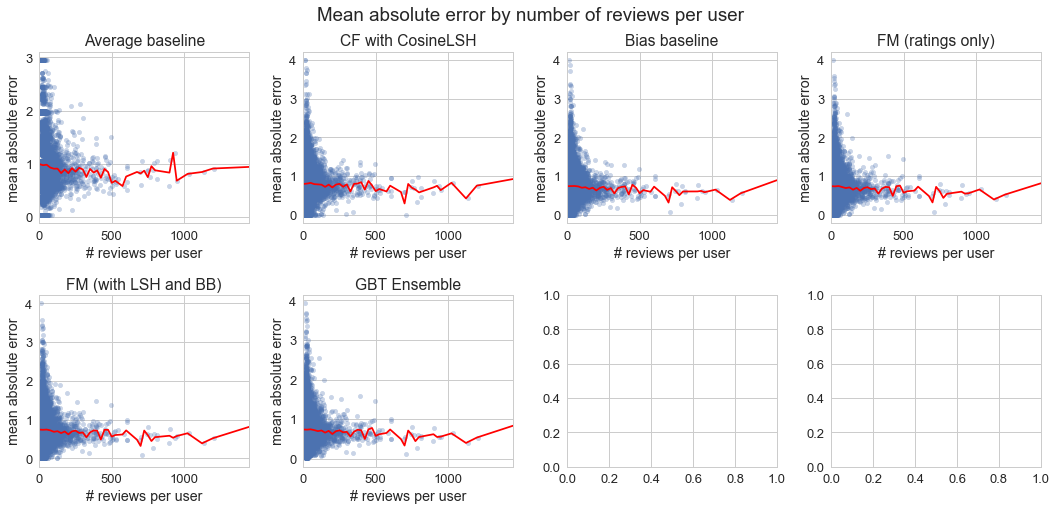

In [13]:
reviews_per_user = data['train'].groupby('user')['rating'].size()
reviews_per_user.name = 'count'
err_per_user = data['test'].groupby('user')[errors].mean()
counts_and_errors_per_user = pd.concat([reviews_per_user, err_per_user], axis = 1)
counts_and_errors_per_user = counts_and_errors_per_user[counts_and_errors_per_user.notnull().all(axis = 1)]

fig, axes = plt.subplots(2, 4, figsize = (15,7))
axes = axes.flatten()
titles = ['Average baseline', 'CF with CosineLSH', 'Bias baseline', 'FM (ratings only)', 'FM (with LSH and BB)',
          'GBT Ensemble']
for index, err, title in zip(range(len(errors)), errors, titles):
    counts_and_errors_per_user.plot(kind = 'scatter', x = 'count', y = err, alpha=0.3,
                                   ax = axes[index])
    counts_and_errors_per_user.groupby(counts_and_errors_per_user['count'] // 25 * 25)\
        [err].mean().plot(ax=axes[index], color = 'red')
    axes[index].set(title = title, ylabel = 'mean absolute error', xlabel = '# reviews per user')

plt.suptitle('Mean absolute error by number of reviews per user', x=0.5, y=1.02)
plt.tight_layout()

# Performance on popular items

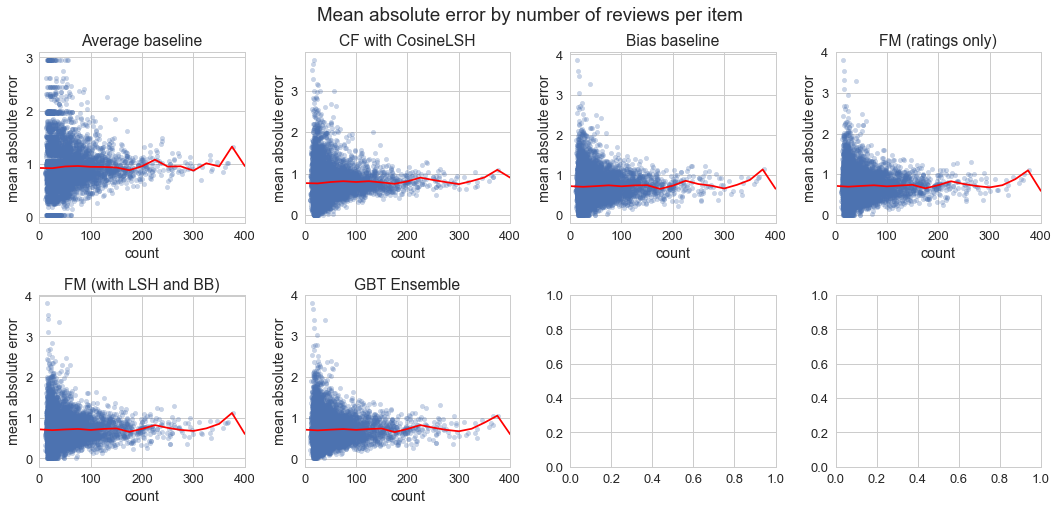

In [14]:
reviews_per_item = data['train'].groupby('item')['rating'].size()
reviews_per_item.name = 'count'
err_per_item = data['test'].groupby('item')[errors].mean()
counts_and_errors_per_item = pd.concat([reviews_per_item, err_per_item], axis = 1)
counts_and_errors_per_item = counts_and_errors_per_item[counts_and_errors_per_item.notnull().all(axis = 1)]

fig, axes = plt.subplots(2, 4, figsize = (15,7))
axes = axes.flatten()
titles = ['Average baseline', 'CF with CosineLSH', 'Bias baseline', 'FM (ratings only)', 'FM (with LSH and BB)',
          'GBT Ensemble']
for index, err, title in zip(range(len(errors)), errors, titles):
    counts_and_errors_per_item.plot(kind = 'scatter', x = 'count', y = err, alpha=0.3,
                                   ax = axes[index])
    axes[index].set(title = title, ylabel = 'mean absolute error', xlabel = '# reviews per item')
    counts_and_errors_per_item.groupby(counts_and_errors_per_item['count'] // 25 * 25)\
        [err].mean().plot(ax=axes[index], color='red')

plt.suptitle('Mean absolute error by number of reviews per item', x=0.5, y=1.02)
plt.tight_layout()

# Performance by release year

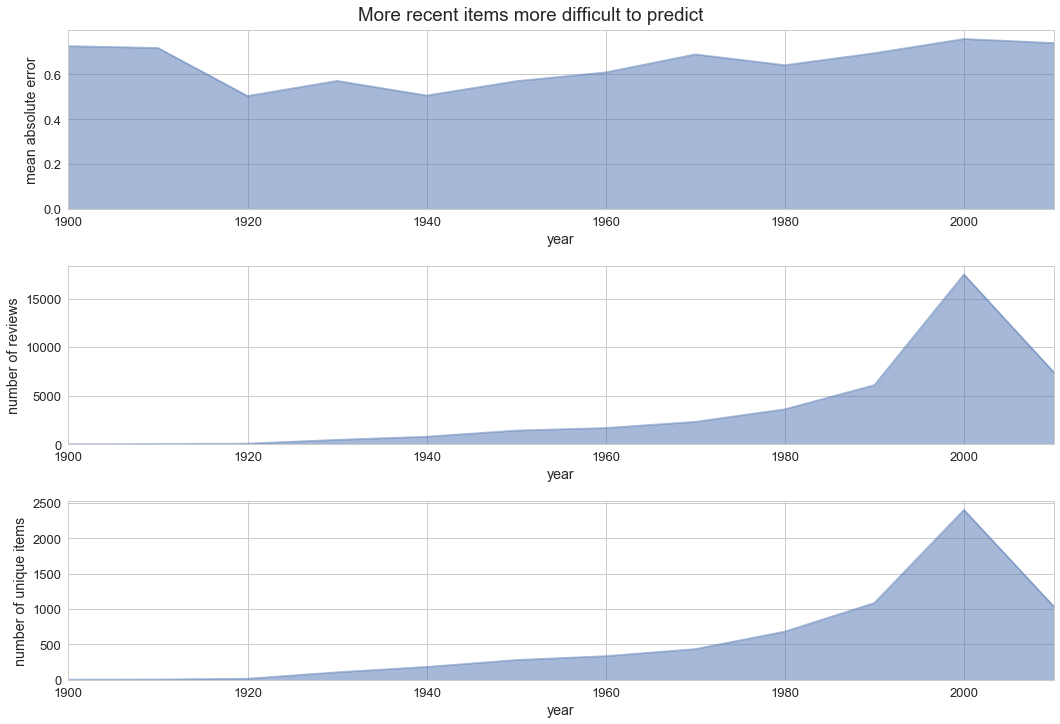

In [92]:
fig, axes = plt.subplots(3, 1, figsize = (15,10))
decades = data['test'].groupby(data['test']['year'] // 10 * 10)
decades['err_ensemble'].mean().plot(kind = 'area', ax = axes[0], alpha = 0.5)                                         
decades['item'].count().plot(kind = 'area', ax = axes[1], alpha = 0.5)
decades['item'].agg(pd.Series.nunique).plot(kind = 'area', ax = axes[2], alpha = 0.5)

axes[0].set(ylabel = 'mean absolute error')
axes[1].set(ylabel = 'number of reviews')
axes[2].set(ylabel = 'number of unique items')

plt.suptitle('More recent items more are difficult to predict', x=0.5, y=1.01)
plt.tight_layout()

# Performance by MPAA Rating

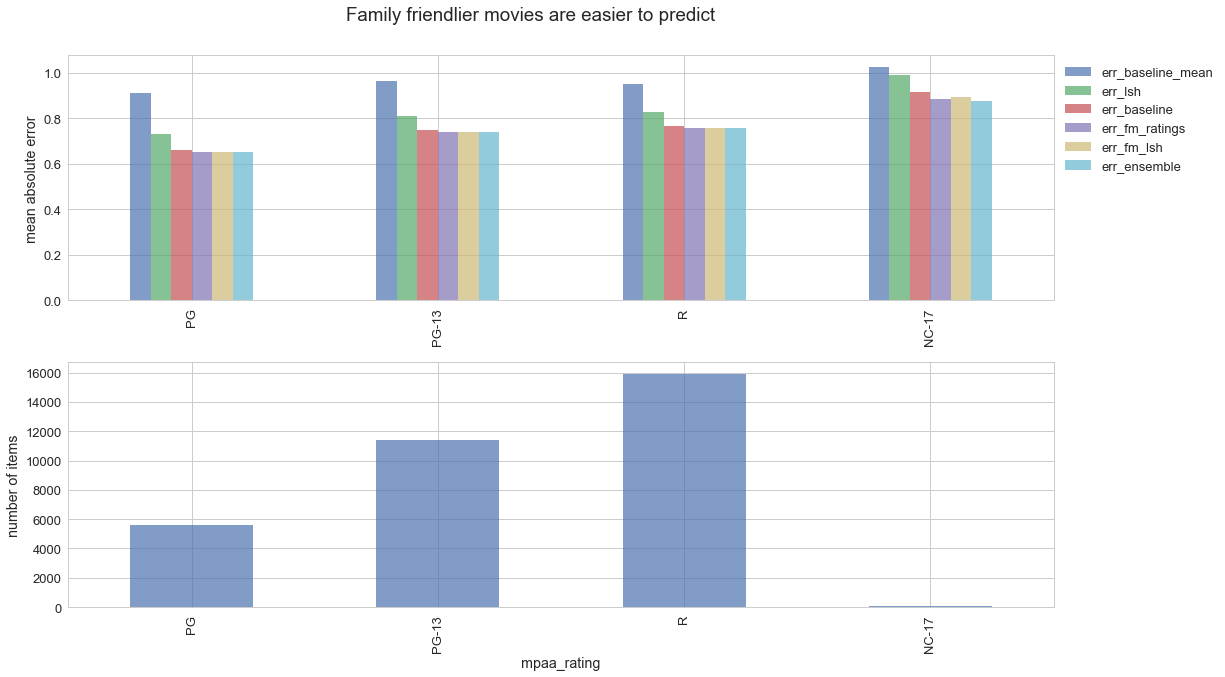

In [99]:
fig, axes = plt.subplots(2, 1, figsize = (15,9))

movies = data['test'][data['test']['mpaa_rating'].isin(['PG', 'PG-13','R', 'NC-17'])]
grouped = movies.groupby('mpaa_rating')[errors].mean()
grouped.index = pd.CategoricalIndex(data=grouped.index, categories=['PG', 'PG-13', 'R', 'NC-17'], ordered=True)
grouped = grouped.sort_index()
grouped.plot(kind = 'bar', ax = axes[0], alpha=0.7)
axes[0].legend(bbox_to_anchor = (1,1))
axes[0].set(xlabel = '', ylabel = 'mean absolute error')

grouped2 = movies.groupby('mpaa_rating')['rating'].count()
grouped2.index = pd.CategoricalIndex(data=grouped2.index, categories=['PG', 'PG-13', 'R', 'NC-17'], ordered=True)
grouped2 = grouped2.sort_index()
grouped2.plot(kind = 'bar', ax = axes[1], alpha=0.7)
axes[1].set(ylabel = 'number of items')

plt.suptitle('Family friendlier movies are easier to predict', x=0.5, y=1.05)
plt.tight_layout()